In [1]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler
from pygrinder import mcar, seq_missing, block_missing
from pypots.imputation import SAITS

from pypots.utils.metrics import calc_mae, calc_mse, calc_mre

from scipy.interpolate import interp1d

import torch
import torch.nn as nn
from sklearn.impute import KNNImputer

from torch.utils.data import DataLoader, TensorDataset, random_split

from matplotlib.widgets import Slider
import ipywidgets as widgets
from ipywidgets import interact

from scipy.fft import fft
from scipy.ndimage import gaussian_filter


2025-01-08 09:47:49.667654: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 09:47:49.695344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 09:47:49.695366: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 09:47:49.695387: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 09:47:49.701155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A


████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



/home/gperez@gaps_domain.ssr.upm.es/.local/lib/python3.10/site-packages/pypots/nn/modules/reformer/local_attention.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/home/gperez@gaps_domain.ssr.upm.es/.local/lib/python3.10/site-packages/pypots/nn/modules/reformer/local_attention.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)


# load data and reprocessing

## load datas

In [2]:
instances_dict_path_train = './instances_dict_train.json'
with open(instances_dict_path_train, 'r') as f:
    instances_dict_train = json.load(f)
    
instances_dict_path_test = './instances_dict_test.json'
with open(instances_dict_path_test, 'r') as f:
    instances_dict_test = json.load(f)

smoothpur_1_4_train = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Train/SmoothPur_1_4_Ar.npy')
smoothpur_5_8_train = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Train/SmoothPur_5_8_Ar.npy')
smoothpur_9_10_train = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Train/SmoothPur_9_10_Ar.npy')
smoothpur_11_12_train = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Train/SmoothPur_11_12_Ar.npy')

smoothpur_1_4_test = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Test/SmoothPur_1_4_Ar.npy')
smoothpur_5_8_test = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Test/SmoothPur_5_8_Ar.npy')
smoothpur_9_10_test = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Test/SmoothPur_9_10_Ar.npy')
smoothpur_11_12_test = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Test/SmoothPur_11_12_Ar.npy')

smoothpur_1_4_train_ori = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Train/SmoothPur_1_4.npy')
smoothpur_5_8_train_ori = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Train/SmoothPur_5_8.npy')
smoothpur_9_10_train_ori = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Train/SmoothPur_9_10.npy')
smoothpur_11_12_train_ori = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Train/SmoothPur_11_12.npy')

smoothpur_1_4_test_ori = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Test/SmoothPur_1_4.npy')
smoothpur_5_8_test_ori = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Test/SmoothPur_5_8.npy')
smoothpur_9_10_test_ori = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Test/SmoothPur_9_10.npy')
smoothpur_11_12_test_ori = np.load('/home/gperez@gaps_domain.ssr.upm.es/Mehdi/SAITS-imputation-main/Test/SmoothPur_11_12.npy')

print('TRAIN')
print(instances_dict_train)
print('length of instances_dict : ' ,len(instances_dict_train))
print('-' * 100)
print('length of smoothpur_1_4 : ' ,len(smoothpur_1_4_train))
print('length of smoothpur_5_8 : ' ,len(smoothpur_5_8_train))
print('length of smoothpur_9_10 : ' ,len(smoothpur_9_10_train))
print('length of smoothpur_11_12 : ' ,len(smoothpur_11_12_train))
print('-' * 100)
print('type of smoothpur_1_4 : ' , type(smoothpur_1_4_train))
print('type of smoothpur_5_8 : ' , type(smoothpur_5_8_train))
print('type of smoothpur_9_10 : ' , type(smoothpur_9_10_train))
print('type of smoothpur_11_12 : ' , type(smoothpur_11_12_train))
print('-' * 100)
print('shape of smoothpur_1_4 : ' , smoothpur_1_4_train.shape)
print('shape of smoothpur_5_8 : ' , smoothpur_5_8_train.shape)
print('shape of smoothpur_9_10 : ' , smoothpur_9_10_train.shape)
print('shape of smoothpur_11_12 : ' , smoothpur_11_12_train.shape)

print('TEST')
print(instances_dict_test)
print('length of instances_dict : ' ,len(instances_dict_test))
print('-' * 100)
print('length of smoothpur_1_4 : ' ,len(smoothpur_1_4_test))
print('length of smoothpur_5_8 : ' ,len(smoothpur_5_8_test))
print('length of smoothpur_9_10 : ' ,len(smoothpur_9_10_test))
print('length of smoothpur_11_12 : ' ,len(smoothpur_11_12_test))
print('-' * 100)
print('type of smoothpur_1_4 : ' , type(smoothpur_1_4_test))
print('type of smoothpur_5_8 : ' , type(smoothpur_5_8_test))
print('type of smoothpur_9_10 : ' , type(smoothpur_9_10_test))
print('type of smoothpur_11_12 : ' , type(smoothpur_11_12_test))
print('-' * 100)
print('shape of smoothpur_1_4 : ' , smoothpur_1_4_test.shape)
print('shape of smoothpur_5_8 : ' , smoothpur_5_8_test.shape)
print('shape of smoothpur_9_10 : ' , smoothpur_9_10_test.shape)
print('shape of smoothpur_11_12 : ' , smoothpur_11_12_test.shape)

TRAIN
{'0': 'HGJ003', '1': 'HG005_V2', '2': 'HG050_V2', '3': 'HF026', '4': 'HF010_V2', '5': 'HG052_V2', '6': 'HG015_V2', '7': 'HG056', '8': 'HG054', '9': 'HG031_V2', '10': 'HG053_v2', '11': 'HF011', '12': 'HF012', '13': 'HG057', '14': 'HG073', '15': 'HG037_V2', '16': 'HF019', '17': 'HGJ009', '18': 'HF009', '19': 'HF018', '20': 'HG002', '21': 'HG047', '22': 'HG014_V2', '23': 'HG036_V2', '24': 'HGJ012', '25': 'HF017', '26': 'HG009', '27': 'HG011', '28': 'HG010', '29': 'HG039_V2', '30': 'HG059', '31': 'HG035_V2', '32': 'HG001_V2', '33': 'HG016', '34': 'HG003', '35': 'HF009_V2', '36': 'HF022', '37': 'HG072', '38': 'HG038_V2', '39': 'HG039', '40': 'HG049', '41': 'HG064_V2', '42': 'HG055_V2', '43': 'HG002_V2', '44': 'HG006_V2', '45': 'HF016_V2', '46': 'HG067', '47': 'HG064', '48': 'HG023_V2', '49': 'HF027', '50': 'HG031', '51': 'HG034', '52': 'HG012_V2', '53': 'HG071', '54': 'HGJ004', '55': 'HG051', '56': 'HGJ008', '57': 'HG072_V2', '58': 'HG042', '59': 'HF031', '60': 'HG065', '61': 'HF030_V

## utility functions

In [3]:
def downsample(signals, new_len):
    downsampled_signals = []
    for signal in signals:
        signal = signal.reshape(-1)  # Flatten the signal
        downsample_factor = len(signal) // new_len
        indices = np.arange(0, len(signal), downsample_factor)
        downsampled_signal = signal[indices[:new_len]]  # Ensure the length matches new_len
        downsampled_signals.append(downsampled_signal)
    return np.array(downsampled_signals)

In [4]:
def flatten_smoothpur_1_8(original_arr):
    arr_shape = original_arr.shape
    flattened_list = []
    for i in range(arr_shape[0]):
      for j in range(arr_shape[1]):
        flattened_list.append(original_arr[i][j][0])
        flattened_list.append(original_arr[i][j][1])
    flattened_arr = np.array(flattened_list)
    return flattened_arr

In [5]:
def reform_smoothpur_1_8(flattened_arr, original_arr):
    arr_shape = original_arr.shape
    reshaped_arr = flattened_arr.reshape((154, 4, 2, 15000))
    target_values = np.empty((154, 4, 1, 15000))
    for i in range(arr_shape[0]):
        for j in range(arr_shape[1]):
            target = original_arr[i][j][2]
            target_values[i][j][0] = target
    reformed_arr = np.concatenate((reshaped_arr, target_values), axis=2)
    return reformed_arr

In [6]:
def flatten_Target_1_8(original_arr):
    arr_shape = original_arr.shape
    flattened_list = []
    for i in range(arr_shape[0]):
      for j in range(arr_shape[1]):
        flattened_list.append(original_arr[i][j][2])
        flattened_list.append(original_arr[i][j][2])
    flattened_arr = np.array(flattened_list)
    return flattened_arr

In [7]:
def flatten_Target_9_12(original_arr):
    arr_shape = original_arr.shape
    flattened_x_list = []
    flattened_y_list = []
    for i in range(arr_shape[0]):
      for j in range(arr_shape[1]):
        flattened_x_list.append(original_arr[i][j][2][0])
        flattened_x_list.append(original_arr[i][j][2][0])
        flattened_y_list.append(original_arr[i][j][2][1])
        flattened_y_list.append(original_arr[i][j][2][1])
    flattened_x_arr = np.array(flattened_x_list)
    flattened_y_arr = np.array(flattened_y_list)
    return flattened_x_arr, flattened_y_arr

In [8]:
def reform_smoothpur_1_8_500(flattened_arr):
    reshaped_arr = flattened_arr.reshape((154, 4, 2, 500))
    return reshaped_arr

In [9]:
def flatten_smoothpur_9_12(original_arr):
    arr_shape = original_arr.shape
    flattened_x_list = []
    flattened_y_list = []
    for i in range(arr_shape[0]):
      for j in range(arr_shape[1]):
        flattened_x_list.append(original_arr[i][j][0][0])
        flattened_x_list.append(original_arr[i][j][0][1])
        flattened_y_list.append(original_arr[i][j][1][0])
        flattened_y_list.append(original_arr[i][j][1][1])
    flattened_x_arr = np.array(flattened_x_list)
    flattened_y_arr = np.array(flattened_y_list)
    return flattened_x_arr, flattened_y_arr

In [10]:
def reform_smoothpur_9_12(flattened_x_arr,flattened_y_arr, original_arr):
    arr_shape = original_arr.shape
    reshaped_x_arr = flattened_x_arr.reshape((154, 2, 1, 2, 15000))
    reshaped_y_arr = flattened_y_arr.reshape((154, 2, 1, 2, 15000))
    reformed_signal_arr = np.concatenate((reshaped_x_arr, reshaped_y_arr), axis=2)
    target_x_values = np.empty((154, 2, 1, 1, 15000))
    target_y_values = np.empty((154, 2, 1, 1, 15000))
    for i in range(arr_shape[0]):
        for j in range(arr_shape[1]):
            targetx = original_arr[i][j][2][0]
            targety = original_arr[i][j][2][1]
            target_x_values[i][j][0][0] = targetx
            target_y_values[i][j][0][0] = targety
    reformed_target_arr = np.concatenate((target_x_values, target_y_values), axis=3)
    total_reformed_arr = np.concatenate((reformed_signal_arr, reformed_target_arr), axis=2)
    return total_reformed_arr

In [11]:
def reform_smoothpur_9_12_500(flattened_x_arr,flattened_y_arr):
    reshaped_x_arr = flattened_x_arr.reshape((154, 2, 1, 2, 500))
    reshaped_y_arr = flattened_y_arr.reshape((154, 2, 1, 2, 500))
    reformed_signal_arr = np.concatenate((reshaped_x_arr, reshaped_y_arr), axis=2)
    return reformed_signal_arr

In [12]:
def calculate_metrics(predicted_signals, original_signals, indicating_mask):
    
    # Apply the mask to filter out only the points where we want to calculate the metrics
    masked_predicted = predicted_signals[indicating_mask]
    masked_original = original_signals[indicating_mask]

    # Calculate MAE
    mae = np.mean(np.abs(masked_predicted - masked_original))

    # Calculate MSE
    mse = np.mean((masked_predicted - masked_original) ** 2)

    # Calculate MRE (Mean Relative Error), avoid division by zero
    # nonzero_mask = masked_original != 0
    # mre = np.mean(np.abs((masked_predicted[nonzero_mask] - masked_original[nonzero_mask]) / masked_original[nonzero_mask]))
   # Modify MRE calculation to match SAITS
    mre = np.sum(np.abs(masked_predicted - masked_original)) / np.sum(np.abs(masked_original) + 1e-12)

    return mae, mse, mre


In [13]:
def compute_all_metrics(imputed_signal, original_signal, indicating_mask):
    
    num_signals, signal_length = original_signal.shape
    high_freq=30
    low_freq=0.1
    sampling_rate=1000

    # Initialize lists to store metrics for each signal
    MAE_list = []
    MRE_list = []
    RMSE_list = []
    Sim_list = []
    FSD_list = []
    RMSE_F_list = []
    RMSE_F_low_list = []
    RMSE_F_high_list = []

    # Define frequency bins for low and high frequencies
    freq_bins = np.fft.rfftfreq(signal_length, d=1/sampling_rate)
    low_freq_indices = np.where(freq_bins <= low_freq)[0]
    high_freq_indices = np.where(freq_bins >= high_freq)[0]

    # Loop over each signal
    for i in range(num_signals):
        orig_sig = original_signal[i, :]
        imp_sig = imputed_signal[i, :]
        mask = indicating_mask[i, :]

        # Ensure signals are 1D arrays
        orig_sig = np.ravel(orig_sig)
        imp_sig = np.ravel(imp_sig)
        mask = np.ravel(mask)

        # If there are no imputed positions in this signal, skip evaluation
        if not np.any(mask):
            continue

        # Extract the values at the imputed positions
        orig_values_at_imputed = orig_sig[mask]
        imp_values_at_imputed = imp_sig[mask]

        # Time Domain Metrics
        # MAE
        mae = np.mean(np.abs(orig_values_at_imputed - imp_values_at_imputed))
        MAE_list.append(mae)

        # MRE
        with np.errstate(divide='ignore', invalid='ignore'):
            relative_errors = np.abs((orig_values_at_imputed - imp_values_at_imputed) / orig_values_at_imputed)
            relative_errors = np.nan_to_num(relative_errors, nan=0.0, posinf=0.0, neginf=0.0)
        mre = np.mean(relative_errors)
        MRE_list.append(mre)

        # RMSE
        mse = np.mean((orig_values_at_imputed - imp_values_at_imputed) ** 2)
        rmse = np.sqrt(mse)
        RMSE_list.append(rmse)

        # Similarity Metric (Sim)
        orig_mean = np.mean(orig_values_at_imputed)
        imp_mean = np.mean(imp_values_at_imputed)
        numerator = np.sum((orig_values_at_imputed - orig_mean) * (imp_values_at_imputed - imp_mean))
        denominator = np.sqrt(np.sum((orig_values_at_imputed - orig_mean) ** 2) * np.sum((imp_values_at_imputed - imp_mean) ** 2))
        sim = numerator / denominator if denominator != 0 else 0
        Sim_list.append(sim)

        # Fraction of Standard Deviation (FSD)
        std_orig = np.std(orig_values_at_imputed)
        fsd = rmse / std_orig if std_orig != 0 else 0
        FSD_list.append(fsd)

        # Frequency Domain Metrics
        # Compute FFTs of the entire signals
        orig_sig_fft = fft(orig_sig)
        imp_sig_fft = fft(imp_sig)

        # Compute RMSE in frequency domain (entire frequency range)
        mse_f = np.mean(np.abs(orig_sig_fft - imp_sig_fft) ** 2)
        rmse_f = np.sqrt(mse_f)
        RMSE_F_list.append(rmse_f)

        # RMSE in Low Frequencies (RMSE_F_low)
        orig_sig_fft_low = orig_sig_fft[low_freq_indices]
        imp_sig_fft_low = imp_sig_fft[low_freq_indices]
        mse_f_low = np.mean(np.abs(orig_sig_fft_low - imp_sig_fft_low) ** 2)
        rmse_f_low = np.sqrt(mse_f_low)
        RMSE_F_low_list.append(rmse_f_low)

        # RMSE in High Frequencies (RMSE_F_high)
        orig_sig_fft_high = orig_sig_fft[high_freq_indices]
        imp_sig_fft_high = imp_sig_fft[high_freq_indices]
        mse_f_high = np.mean(np.abs(orig_sig_fft_high - imp_sig_fft_high) ** 2)
        rmse_f_high = np.sqrt(mse_f_high)
        RMSE_F_high_list.append(rmse_f_high)

    # Aggregate metrics
    metrics = {
        'MAE_mean': np.mean(MAE_list) if MAE_list else None,
        # 'MAE_std': np.std(MAE_list),
        'MRE_mean': np.mean(MRE_list) if MRE_list else None,
        # 'MRE_std': np.std(MRE_list),
        'RMSE_mean': np.mean(RMSE_list) if RMSE_list else None,
        # 'RMSE_std': np.std(RMSE_list),
        'Sim_mean': np.mean(Sim_list) if Sim_list else None,
        # 'Sim_std': np.std(Sim_list),
        'FSD_mean': np.mean(FSD_list) if FSD_list else None,
        # 'FSD_std': np.std(FSD_list),
        'RMSE_F_mean': np.mean(RMSE_F_list) if RMSE_F_list else None,
         # 'RMSE_F_std': np.std(RMSE_F_list),
        'RMSE_F_Low_mean': np.mean(RMSE_F_low_list) if RMSE_F_low_list else None,
        # 'RMSE_F_Low_std': np.std(RMSE_F_low_list),
        'RMSE_F_High_mean': np.mean(RMSE_F_high_list) if RMSE_F_high_list else None,
        # 'RMSE_F_High_std': np.std(RMSE_F_high_list)
    }

    return metrics

In [14]:
print("TRAIN")

flat_1_4_train = flatten_smoothpur_1_8(smoothpur_1_4_train)
flat_5_8_train = flatten_smoothpur_1_8(smoothpur_5_8_train)
flat_x_9_10_train, flat_y_9_10_train = flatten_smoothpur_9_12(smoothpur_9_10_train)
flat_x_11_12_train, flat_y_11_12_train = flatten_smoothpur_9_12(smoothpur_11_12_train)

mean_1_4_train = np.nanmean(flat_1_4_train)
std_1_4_train = np.nanstd(flat_1_4_train)
flat_1_4_normalized_train = (flat_1_4_train - mean_1_4_train) / std_1_4_train
# flat_1_4_normalized = min_max_normalize(flat_1_4)

mean_5_8_train = np.nanmean(flat_5_8_train)
std_5_8_train = np.nanstd(flat_5_8_train)
flat_5_8_normalized_train = (flat_5_8_train - mean_5_8_train) / std_5_8_train
# flat_5_8_normalized = min_max_normalize(flat_5_8)


mean_x_9_10_train = np.nanmean(flat_x_9_10_train)
std_x_9_10_train = np.nanstd(flat_x_9_10_train)
flat_x_9_10_normalized_train = (flat_x_9_10_train - mean_x_9_10_train) / std_x_9_10_train
# flat_x_9_10_normalized = min_max_normalize(flat_x_9_10)

mean_y_9_10_train = np.nanmean(flat_y_9_10_train)
std_y_9_10_train = np.nanstd(flat_y_9_10_train)
flat_y_9_10_normalized_train = (flat_y_9_10_train - mean_y_9_10_train) / std_y_9_10_train
# flat_y_9_10_normalized = min_max_normalize(flat_y_9_10)

mean_x_11_12_train = np.nanmean(flat_x_11_12_train)
std_x_11_12_train = np.nanstd(flat_x_11_12_train)
flat_x_11_12_normalized_train = (flat_x_11_12_train - mean_x_11_12_train) / std_x_11_12_train
# flat_x_11_12_normalized = min_max_normalize(flat_x_11_12)

mean_y_11_12_train = np.nanmean(flat_y_11_12_train)
std_y_11_12_train = np.nanstd(flat_y_11_12_train)
flat_y_11_12_normalized_train = (flat_y_11_12_train - mean_y_11_12_train) / std_y_11_12_train
# flat_y_11_12_normalized = min_max_normalize(flat_y_11_12)

print('shape of flattened smoothpur_1_4 :', flat_1_4_normalized_train.shape)
print('shape of flattened smoothpur_5_8 :', flat_5_8_normalized_train.shape)
print('shape of flattened smoothpur_x_9_10 :', flat_x_9_10_normalized_train.shape)
print('shape of flattened smoothpur_y_9_10 :', flat_y_9_10_normalized_train.shape)
print('shape of flattened smoothpur_x_11_12 :', flat_x_11_12_normalized_train.shape)
print('shape of flattened smoothpur_y_11_12 :', flat_y_11_12_normalized_train.shape)

print("TEST")

flat_1_4_test = flatten_smoothpur_1_8(smoothpur_1_4_test)
flat_5_8_test = flatten_smoothpur_1_8(smoothpur_5_8_test)
flat_x_9_10_test, flat_y_9_10_test = flatten_smoothpur_9_12(smoothpur_9_10_test)
flat_x_11_12_test, flat_y_11_12_test = flatten_smoothpur_9_12(smoothpur_11_12_test)

mean_1_4_test = np.nanmean(flat_1_4_test)
std_1_4_test = np.nanstd(flat_1_4_test)
flat_1_4_normalized_test = (flat_1_4_test - mean_1_4_test) / std_1_4_test
# flat_1_4_normalized = min_max_normalize(flat_1_4)

mean_5_8_test = np.nanmean(flat_5_8_test)
std_5_8_test = np.nanstd(flat_5_8_test)
flat_5_8_normalized_test = (flat_5_8_test - mean_5_8_test) / std_5_8_test
# flat_5_8_normalized = min_max_normalize(flat_5_8)


mean_x_9_10_test = np.nanmean(flat_x_9_10_test)
std_x_9_10_test = np.nanstd(flat_x_9_10_test)
flat_x_9_10_normalized_test = (flat_x_9_10_test - mean_x_9_10_test) / std_x_9_10_test
# flat_x_9_10_normalized = min_max_normalize(flat_x_9_10)

mean_y_9_10_test = np.nanmean(flat_y_9_10_test)
std_y_9_10_test = np.nanstd(flat_y_9_10_test)
flat_y_9_10_normalized_test = (flat_y_9_10_test - mean_y_9_10_test) / std_y_9_10_test
# flat_y_9_10_normalized = min_max_normalize(flat_y_9_10)

mean_x_11_12_test = np.nanmean(flat_x_11_12_test)
std_x_11_12_test = np.nanstd(flat_x_11_12_test)
flat_x_11_12_normalized_test = (flat_x_11_12_test - mean_x_11_12_test) / std_x_11_12_test
# flat_x_11_12_normalized = min_max_normalize(flat_x_11_12)

mean_y_11_12_test = np.nanmean(flat_y_11_12_test)
std_y_11_12_test = np.nanstd(flat_y_11_12_test)
flat_y_11_12_normalized_test = (flat_y_11_12_test - mean_y_11_12_test) / std_y_11_12_test
# flat_y_11_12_normalized = min_max_normalize(flat_y_11_12)

print('shape of flattened smoothpur_1_4 :', flat_1_4_normalized_test.shape)
print('shape of flattened smoothpur_5_8 :', flat_5_8_normalized_test.shape)
print('shape of flattened smoothpur_x_9_10 :', flat_x_9_10_normalized_test.shape)
print('shape of flattened smoothpur_y_9_10 :', flat_y_9_10_normalized_test.shape)
print('shape of flattened smoothpur_x_11_12 :', flat_x_11_12_normalized_test.shape)
print('shape of flattened smoothpur_y_11_12 :', flat_y_11_12_normalized_test.shape)

TRAIN
shape of flattened smoothpur_1_4 : (1096, 15000)
shape of flattened smoothpur_5_8 : (1096, 15000)
shape of flattened smoothpur_x_9_10 : (548, 15000)
shape of flattened smoothpur_y_9_10 : (548, 15000)
shape of flattened smoothpur_x_11_12 : (548, 15000)
shape of flattened smoothpur_y_11_12 : (548, 15000)
TEST
shape of flattened smoothpur_1_4 : (280, 15000)
shape of flattened smoothpur_5_8 : (280, 15000)
shape of flattened smoothpur_x_9_10 : (140, 15000)
shape of flattened smoothpur_y_9_10 : (140, 15000)
shape of flattened smoothpur_x_11_12 : (140, 15000)
shape of flattened smoothpur_y_11_12 : (140, 15000)


In [15]:
print("TRAIN")

flat_1_4_train_ori = flatten_smoothpur_1_8(smoothpur_1_4_train_ori)
flat_5_8_train_ori = flatten_smoothpur_1_8(smoothpur_5_8_train_ori)
flat_x_9_10_train_ori, flat_y_9_10_train_ori = flatten_smoothpur_9_12(smoothpur_9_10_train_ori)
flat_x_11_12_train_ori, flat_y_11_12_train_ori = flatten_smoothpur_9_12(smoothpur_11_12_train_ori)

mean_1_4_train_ori = np.nanmean(flat_1_4_train_ori)
std_1_4_train_ori = np.nanstd(flat_1_4_train_ori)
flat_1_4_normalized_train_ori = (flat_1_4_train_ori - mean_1_4_train_ori) / std_1_4_train_ori
# flat_1_4_normalized = min_max_normalize(flat_1_4)

mean_5_8_train_ori = np.nanmean(flat_5_8_train_ori)
std_5_8_train_ori = np.nanstd(flat_5_8_train_ori)
flat_5_8_normalized_train_ori = (flat_5_8_train_ori - mean_5_8_train_ori) / std_5_8_train_ori
# flat_5_8_normalized = min_max_normalize(flat_5_8)


mean_x_9_10_train_ori = np.nanmean(flat_x_9_10_train_ori)
std_x_9_10_train_ori = np.nanstd(flat_x_9_10_train_ori)
flat_x_9_10_normalized_train_ori = (flat_x_9_10_train_ori - mean_x_9_10_train_ori) / std_x_9_10_train_ori
# flat_x_9_10_normalized = min_max_normalize(flat_x_9_10)

mean_y_9_10_train_ori = np.nanmean(flat_y_9_10_train_ori)
std_y_9_10_train_ori = np.nanstd(flat_y_9_10_train_ori)
flat_y_9_10_normalized_train_ori = (flat_y_9_10_train_ori - mean_y_9_10_train_ori) / std_y_9_10_train_ori
# flat_y_9_10_normalized = min_max_normalize(flat_y_9_10)

mean_x_11_12_train_ori = np.nanmean(flat_x_11_12_train_ori)
std_x_11_12_train_ori = np.nanstd(flat_x_11_12_train_ori)
flat_x_11_12_normalized_train_ori = (flat_x_11_12_train_ori - mean_x_11_12_train_ori) / std_x_11_12_train_ori
# flat_x_11_12_normalized = min_max_normalize(flat_x_11_12)

mean_y_11_12_train_ori = np.nanmean(flat_y_11_12_train_ori)
std_y_11_12_train_ori = np.nanstd(flat_y_11_12_train_ori)
flat_y_11_12_normalized_train_ori = (flat_y_11_12_train_ori - mean_y_11_12_train_ori) / std_y_11_12_train_ori
# flat_y_11_12_normalized = min_max_normalize(flat_y_11_12)

print('shape of flattened smoothpur_1_4 :', flat_1_4_normalized_train_ori.shape)
print('shape of flattened smoothpur_5_8 :', flat_5_8_normalized_train_ori.shape)
print('shape of flattened smoothpur_x_9_10 :', flat_x_9_10_normalized_train_ori.shape)
print('shape of flattened smoothpur_y_9_10 :', flat_y_9_10_normalized_train_ori.shape)
print('shape of flattened smoothpur_x_11_12 :', flat_x_11_12_normalized_train_ori.shape)
print('shape of flattened smoothpur_y_11_12 :', flat_y_11_12_normalized_train_ori.shape)

print("TEST")

flat_1_4_test_ori = flatten_smoothpur_1_8(smoothpur_1_4_test_ori)
flat_5_8_test_ori = flatten_smoothpur_1_8(smoothpur_5_8_test_ori)
flat_x_9_10_test_ori, flat_y_9_10_test_ori = flatten_smoothpur_9_12(smoothpur_9_10_test_ori)
flat_x_11_12_test_ori, flat_y_11_12_test_ori = flatten_smoothpur_9_12(smoothpur_11_12_test_ori)

mean_1_4_test_ori = np.nanmean(flat_1_4_test_ori)
std_1_4_test_ori = np.nanstd(flat_1_4_test_ori)
flat_1_4_normalized_test_ori = (flat_1_4_test_ori - mean_1_4_test_ori) / std_1_4_test_ori
# flat_1_4_normalized = min_max_normalize(flat_1_4)

mean_5_8_test_ori = np.nanmean(flat_5_8_test_ori)
std_5_8_test_ori = np.nanstd(flat_5_8_test_ori)
flat_5_8_normalized_test_ori = (flat_5_8_test_ori - mean_5_8_test_ori) / std_5_8_test_ori
# flat_5_8_normalized = min_max_normalize(flat_5_8)


mean_x_9_10_test_ori = np.nanmean(flat_x_9_10_test_ori)
std_x_9_10_test_ori = np.nanstd(flat_x_9_10_test_ori)
flat_x_9_10_normalized_test_ori = (flat_x_9_10_test_ori - mean_x_9_10_test_ori) / std_x_9_10_test_ori
# flat_x_9_10_normalized = min_max_normalize(flat_x_9_10)

mean_y_9_10_test_ori = np.nanmean(flat_y_9_10_test_ori)
std_y_9_10_test_ori = np.nanstd(flat_y_9_10_test_ori)
flat_y_9_10_normalized_test_ori = (flat_y_9_10_test_ori - mean_y_9_10_test_ori) / std_y_9_10_test_ori
# flat_y_9_10_normalized = min_max_normalize(flat_y_9_10)

mean_x_11_12_test_ori = np.nanmean(flat_x_11_12_test_ori)
std_x_11_12_test_ori = np.nanstd(flat_x_11_12_test_ori)
flat_x_11_12_normalized_test_ori = (flat_x_11_12_test_ori - mean_x_11_12_test_ori) / std_x_11_12_test_ori
# flat_x_11_12_normalized = min_max_normalize(flat_x_11_12)

mean_y_11_12_test_ori = np.nanmean(flat_y_11_12_test_ori)
std_y_11_12_test_ori = np.nanstd(flat_y_11_12_test_ori)
flat_y_11_12_normalized_test_ori = (flat_y_11_12_test_ori - mean_y_11_12_test_ori) / std_y_11_12_test_ori
# flat_y_11_12_normalized = min_max_normalize(flat_y_11_12)

print('shape of flattened smoothpur_1_4 :', flat_1_4_normalized_test_ori.shape)
print('shape of flattened smoothpur_5_8 :', flat_5_8_normalized_test_ori.shape)
print('shape of flattened smoothpur_x_9_10 :', flat_x_9_10_normalized_test_ori.shape)
print('shape of flattened smoothpur_y_9_10 :', flat_y_9_10_normalized_test_ori.shape)
print('shape of flattened smoothpur_x_11_12 :', flat_x_11_12_normalized_test_ori.shape)
print('shape of flattened smoothpur_y_11_12 :', flat_y_11_12_normalized_test_ori.shape)

TRAIN
shape of flattened smoothpur_1_4 : (1096, 15000)
shape of flattened smoothpur_5_8 : (1096, 15000)
shape of flattened smoothpur_x_9_10 : (548, 15000)
shape of flattened smoothpur_y_9_10 : (548, 15000)
shape of flattened smoothpur_x_11_12 : (548, 15000)
shape of flattened smoothpur_y_11_12 : (548, 15000)
TEST
shape of flattened smoothpur_1_4 : (280, 15000)
shape of flattened smoothpur_5_8 : (280, 15000)
shape of flattened smoothpur_x_9_10 : (140, 15000)
shape of flattened smoothpur_y_9_10 : (140, 15000)
shape of flattened smoothpur_x_11_12 : (140, 15000)
shape of flattened smoothpur_y_11_12 : (140, 15000)


In [16]:
flats_normalized_train = np.concatenate([
    flat_1_4_normalized_train,
    flat_5_8_normalized_train,
    flat_x_9_10_normalized_train,
    flat_y_9_10_normalized_train,
    flat_x_11_12_normalized_train,
    flat_y_11_12_normalized_train
], axis=0)

flats_normalized_test = np.concatenate([
    flat_1_4_normalized_test,
    flat_5_8_normalized_test,
    flat_x_9_10_normalized_test,
    flat_y_9_10_normalized_test,
    flat_x_11_12_normalized_test,
    flat_y_11_12_normalized_test
], axis=0)

flats_normalized_train_ori = np.concatenate([
    flat_1_4_normalized_train_ori,
    flat_5_8_normalized_train_ori,
    flat_x_9_10_normalized_train_ori,
    flat_y_9_10_normalized_train_ori,
    flat_x_11_12_normalized_train_ori,
    flat_y_11_12_normalized_train_ori
], axis=0)

flats_normalized_test_ori = np.concatenate([
    flat_1_4_normalized_test_ori,
    flat_5_8_normalized_test_ori,
    flat_x_9_10_normalized_test_ori,
    flat_y_9_10_normalized_test_ori,
    flat_x_11_12_normalized_test_ori,
    flat_y_11_12_normalized_test_ori
], axis=0)


In [17]:
print("TRAIN")
newL=500

down_1_4_train = downsample(flat_1_4_normalized_train, newL)
down_5_8_train = downsample(flat_5_8_normalized_train, newL)
down_x_9_10_train, down_y_9_10_train = downsample(flat_x_9_10_normalized_train, newL), downsample(flat_y_9_10_normalized_train, newL)
down_x_11_12_train, down_y_11_12_train = downsample(flat_x_11_12_normalized_train, newL), downsample(flat_y_11_12_normalized_train, newL)
downs_train = downsample(flats_normalized_train, newL)

down_1_4_train_ori = downsample(flat_1_4_normalized_train_ori, newL)
down_5_8_train_ori = downsample(flat_5_8_normalized_train_ori, newL)
down_x_9_10_train_ori, down_y_9_10_train_ori = downsample(flat_x_9_10_normalized_train_ori, newL), downsample(flat_y_9_10_normalized_train_ori, newL)
down_x_11_12_train_ori, down_y_11_12_train_ori = downsample(flat_x_11_12_normalized_train_ori, newL), downsample(flat_y_11_12_normalized_train_ori, newL)
downs_train_ori = downsample(flats_normalized_train_ori, newL)

print('shape of downsampled smoothpur_1_4 :', down_1_4_train.shape)
print('shape of downsampled smoothpur_5_8 :', down_5_8_train.shape)
print('shape of downsampled smoothpur_x_9_10 :', down_x_9_10_train.shape)
print('shape of downsampled smoothpur_y_9_10 :', down_y_9_10_train.shape)
print('shape of downsampled smoothpur_x_11_12 :', down_x_11_12_train.shape)
print('shape of downsampled smoothpur_y_11_12 :', down_y_11_12_train.shape)
print('shape of downsampled All smoothpurs :', downs_train.shape)

print("TEST")
down_1_4_test = downsample(flat_1_4_normalized_test, newL)
down_5_8_test = downsample(flat_5_8_normalized_test, newL)
down_x_9_10_test, down_y_9_10_test = downsample(flat_x_9_10_normalized_test, newL), downsample(flat_y_9_10_normalized_test, newL)
down_x_11_12_test, down_y_11_12_test = downsample(flat_x_11_12_normalized_test, newL), downsample(flat_y_11_12_normalized_test, newL)
downs_test = downsample(flats_normalized_test, newL)

down_1_4_test_ori = downsample(flat_1_4_normalized_test_ori, newL)
down_5_8_test_ori = downsample(flat_5_8_normalized_test_ori, newL)
down_x_9_10_test_ori, down_y_9_10_test_ori = downsample(flat_x_9_10_normalized_test_ori, newL), downsample(flat_y_9_10_normalized_test_ori, newL)
down_x_11_12_test_ori, down_y_11_12_test_ori = downsample(flat_x_11_12_normalized_test_ori, newL), downsample(flat_y_11_12_normalized_test_ori, newL)
downs_test_ori = downsample(flats_normalized_test_ori, newL)


print('shape of downsampled smoothpur_1_4 :', down_1_4_test.shape)
print('shape of downsampled smoothpur_5_8 :', down_5_8_test.shape)
print('shape of downsampled smoothpur_x_9_10 :', down_x_9_10_test.shape)
print('shape of downsampled smoothpur_y_9_10 :', down_y_9_10_test.shape)
print('shape of downsampled smoothpur_x_11_12 :', down_x_11_12_test.shape)
print('shape of downsampled smoothpur_y_11_12 :', down_y_11_12_test.shape)
print('shape of downsampled All smoothpurs :', downs_test.shape)

TRAIN
shape of downsampled smoothpur_1_4 : (1096, 500)
shape of downsampled smoothpur_5_8 : (1096, 500)
shape of downsampled smoothpur_x_9_10 : (548, 500)
shape of downsampled smoothpur_y_9_10 : (548, 500)
shape of downsampled smoothpur_x_11_12 : (548, 500)
shape of downsampled smoothpur_y_11_12 : (548, 500)
shape of downsampled All smoothpurs : (4384, 500)
TEST
shape of downsampled smoothpur_1_4 : (280, 500)
shape of downsampled smoothpur_5_8 : (280, 500)
shape of downsampled smoothpur_x_9_10 : (140, 500)
shape of downsampled smoothpur_y_9_10 : (140, 500)
shape of downsampled smoothpur_x_11_12 : (140, 500)
shape of downsampled smoothpur_y_11_12 : (140, 500)
shape of downsampled All smoothpurs : (1120, 500)


# edit from here

In [18]:
print("TRAIN")
exp_1_4_train = np.expand_dims(down_1_4_train, axis=-1)
exp_5_8_train = np.expand_dims(down_5_8_train, axis=-1)
exp_x_9_10_train = np.expand_dims(down_x_9_10_train, axis=-1)
exp_y_9_10_train = np.expand_dims(down_y_9_10_train, axis=-1)
exp_x_11_12_train = np.expand_dims(down_x_11_12_train, axis=-1)
exp_y_11_12_train = np.expand_dims(down_y_11_12_train, axis=-1)
exps_train = np.expand_dims(downs_train, axis=-1)

print("TRAIN")
exp_1_4_train_ori = np.expand_dims(down_1_4_train_ori, axis=-1)
exp_5_8_train_ori = np.expand_dims(down_5_8_train_ori, axis=-1)
exp_x_9_10_train_ori = np.expand_dims(down_x_9_10_train_ori, axis=-1)
exp_y_9_10_train_ori = np.expand_dims(down_y_9_10_train_ori, axis=-1)
exp_x_11_12_train_ori = np.expand_dims(down_x_11_12_train_ori, axis=-1)
exp_y_11_12_train_ori = np.expand_dims(down_y_11_12_train_ori, axis=-1)
exps_train_ori = np.expand_dims(downs_train_ori, axis=-1)


print('shape of expanded smoothpur_1_4 :', exp_1_4_train.shape)
print('shape of expanded smoothpur_5_8 :', exp_5_8_train.shape)
print('shape of expanded smoothpur_x_9_10 :', exp_x_9_10_train.shape)
print('shape of expanded smoothpur_y_9_10 :', exp_y_9_10_train.shape)
print('shape of expanded smoothpur_x_11_12 :', exp_x_11_12_train.shape)
print('shape of expanded smoothpur_y_11_12 :', exp_y_11_12_train.shape)
print('shape of expanded All smoothpur :', exps_train.shape)


print("TEST")
exp_1_4_test = np.expand_dims(down_1_4_test, axis=-1)
exp_5_8_test = np.expand_dims(down_5_8_test, axis=-1)
exp_x_9_10_test = np.expand_dims(down_x_9_10_test, axis=-1)
exp_y_9_10_test = np.expand_dims(down_y_9_10_test, axis=-1)
exp_x_11_12_test = np.expand_dims(down_x_11_12_test, axis=-1)
exp_y_11_12_test = np.expand_dims(down_y_11_12_test, axis=-1)
exps_test = np.expand_dims(downs_test, axis=-1)

exp_1_4_test_ori = np.expand_dims(down_1_4_test_ori, axis=-1)
exp_5_8_test_ori = np.expand_dims(down_5_8_test_ori, axis=-1)
exp_x_9_10_test_ori = np.expand_dims(down_x_9_10_test_ori, axis=-1)
exp_y_9_10_test_ori = np.expand_dims(down_y_9_10_test_ori, axis=-1)
exp_x_11_12_test_ori = np.expand_dims(down_x_11_12_test_ori, axis=-1)
exp_y_11_12_test_ori = np.expand_dims(down_y_11_12_test_ori, axis=-1)
exps_test_ori = np.expand_dims(downs_test_ori, axis=-1)


print('shape of expanded smoothpur_1_4 :', exp_1_4_test.shape)
print('shape of expanded smoothpur_5_8 :', exp_5_8_test.shape)
print('shape of expanded smoothpur_x_9_10 :', exp_x_9_10_test.shape)
print('shape of expanded smoothpur_y_9_10 :', exp_y_9_10_test.shape)
print('shape of expanded smoothpur_x_11_12 :', exp_x_11_12_test.shape)
print('shape of expanded smoothpur_y_11_12 :', exp_y_11_12_test.shape)
print('shape of expanded All smoothpur :', exps_test.shape)

TRAIN
TRAIN
shape of expanded smoothpur_1_4 : (1096, 500, 1)
shape of expanded smoothpur_5_8 : (1096, 500, 1)
shape of expanded smoothpur_x_9_10 : (548, 500, 1)
shape of expanded smoothpur_y_9_10 : (548, 500, 1)
shape of expanded smoothpur_x_11_12 : (548, 500, 1)
shape of expanded smoothpur_y_11_12 : (548, 500, 1)
shape of expanded All smoothpur : (4384, 500, 1)
TEST
shape of expanded smoothpur_1_4 : (280, 500, 1)
shape of expanded smoothpur_5_8 : (280, 500, 1)
shape of expanded smoothpur_x_9_10 : (140, 500, 1)
shape of expanded smoothpur_y_9_10 : (140, 500, 1)
shape of expanded smoothpur_x_11_12 : (140, 500, 1)
shape of expanded smoothpur_y_11_12 : (140, 500, 1)
shape of expanded All smoothpur : (1120, 500, 1)


# SAITS

In [21]:
mask_rate = 0.0001

In [20]:
from pypots.optim import Adam

# Define your custom optimizer
custom_optimizer = Adam(lr=0.0006)  # Set your desired learning rate

## All SAITS

In [54]:
%%time
# ENTRENAMIENTO NORMAL

X_ori = exps_train_ori
np.random.seed(42)
torch.manual_seed(42)
#X = mcar(exps_train, mask_rate)

dataset = {"X": exps_train}

saits = SAITS(n_steps=newL, n_features=1, n_layers=4, d_model=512, n_heads=8, d_k=128, d_v=128, d_ffn=256, dropout=0.2, epochs=300, optimizer=custom_optimizer, model_saving_strategy='better')
saits.fit(dataset)
imputation = saits.impute(dataset)

indicating_mask = np.isnan(X) ^ np.isnan(X_ori)

saits.save("saits_weights/saits_all_artificial.pypots", overwrite=True)
saits.load("saits_weights/saits_all_artificial.pypots")

mae, mse, mre = calculate_metrics(imputation, np.nan_to_num(X_ori), indicating_mask)
print("Trainning metrics")
print(f'MAE: {mae:.3f}, MSE: {mse:.3f}, MRE: {mre:.3f}')

2025-01-05 17:48:35 [INFO]: No given device, using default device: cuda
2025-01-05 17:48:35 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-01-05 17:48:35 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,318,906
2025-01-05 17:48:41 [INFO]: Epoch 001 - training loss: 0.8114
2025-01-05 17:48:46 [INFO]: Epoch 002 - training loss: 0.3426
2025-01-05 17:48:52 [INFO]: Epoch 003 - training loss: 0.2932
2025-01-05 17:48:58 [INFO]: Epoch 004 - training loss: 0.2639
2025-01-05 17:49:04 [INFO]: Epoch 005 - training loss: 0.2333
2025-01-05 17:49:10 [INFO]: Epoch 006 - training loss: 0.2087
2025-01-05 17:49:16 [INFO]: Epoch 007 - training loss: 0.1896
2025-01-05 17:49:22 [INFO]: Epoch 008 - training loss: 0.1735
2025-01-05 17:49:28 [INFO]: Epoch 009 - training loss: 0.1613
2025-01-05 17:49:34 [INFO]: Epoch 010 - training loss: 0.1505
2025-01-05 17:49:40 [INFO]: Epoch 011 - training loss: 0.1416
2025-01-05 17

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import torch

# Datos originales
X_ori = exps_train_ori
np.random.seed(42)
torch.manual_seed(42)

def train_and_evaluate_kfold(X, X_ori, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {"mae": [], "mse": [], "mre": []}

    fold = 1
    for train_index, test_index in kf.split(X):
        print(f"Training fold {fold}/{n_splits}")
        
        # Crear conjuntos de entrenamiento y prueba
        X_train, X_test = X[train_index], X[test_index]
        X_ori_train, X_ori_test = X_ori[train_index], X_ori[test_index]

        dataset_train = {"X": X_train,"X_ori": X_ori_train }
        dataset_test = {"X": X_test,"X_ori": X_ori_test }

        # Crear y entrenar el modelo SAITS
        saits = SAITS(n_steps=newL, n_features=1, n_layers=4, d_model=512, n_heads=8, d_k=128, d_v=128, d_ffn=256, dropout=0.2, epochs=300, optimizer=custom_optimizer, model_saving_strategy='better')

        saits.fit(train_set=dataset_train,val_set=dataset_test)

        # Imputar los valores faltantes
        imputation = saits.impute(dataset_test)

        # Máscara de valores imputados
        indicating_mask = np.isnan(X_test) ^ np.isnan(X_ori_test)

        # Calcular métricas
        mae, mse, mre = calculate_metrics(imputation, np.nan_to_num(X_ori_test), indicating_mask)
        metrics["mae"].append(mae)
        metrics["mse"].append(mse)
        metrics["mre"].append(mre)
        saits.save(F'saits_weights/saits_all_artificial_4_kfolds_{fold}.pypots', overwrite=True)
        print(f"Fold {fold} metrics: MAE: {mae:.3f}, MSE: {mse:.3f}, MRE: {mre:.3f}")

        print(f"Fold {fold} metrics: MAE: {mae:.3f}, MSE: {mse:.3f}, MRE: {mre:.3f}")
        fold += 1

    # Promediar las métricas
    mean_mae = np.mean(metrics["mae"])
    mean_mse = np.mean(metrics["mse"])
    mean_mre = np.mean(metrics["mre"])

    print("\nK-Fold Cross Validation Results")
    print(f"Average MAE: {mean_mae:.3f}, Average MSE: {mean_mse:.3f}, Average MRE: {mean_mre:.3f}")
    
    # Crear boxplots
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.boxplot(metrics["mae"], vert=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))
    plt.title("MAE Boxplot")
    plt.ylabel("MAE")

    plt.subplot(1, 3, 2)
    plt.boxplot(metrics["mse"], vert=True, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
    plt.title("MSE Boxplot")
    plt.ylabel("MSE")

    plt.subplot(1, 3, 3)
    plt.boxplot(metrics["mre"], vert=True, patch_artist=True, boxprops=dict(facecolor="lightcoral"))
    plt.title("MRE Boxplot")
    plt.ylabel("MRE")

    plt.tight_layout()
    plt.show()
    

    return metrics

# Llamar la función con K-Folds
n_splits = 10
metrics = train_and_evaluate_kfold(exps_train, exps_train_ori, n_splits=n_splits)

# Guardar los pesos finales
saits.save("saits_weights/saits_all_artificial_kfolds.pypots", overwrite=True)
saits.load("saits_weights/saits_all_artificial_kfolds.pypots")

2025-01-07 10:16:31 [INFO]: No given device, using default device: cuda
2025-01-07 10:16:31 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-01-07 10:16:31 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,318,906


Training fold 1/10


2025-01-07 10:16:46 [INFO]: Epoch 001 - training loss: 0.8458, validation loss: -0.6435
2025-01-07 10:17:02 [INFO]: Epoch 002 - training loss: 0.3632, validation loss: -0.6675
2025-01-07 10:17:17 [INFO]: Epoch 003 - training loss: 0.3105, validation loss: -0.6424
2025-01-07 10:17:32 [INFO]: Epoch 004 - training loss: 0.2796, validation loss: -0.6825
2025-01-07 10:17:47 [INFO]: Epoch 005 - training loss: 0.2556, validation loss: -0.6955
2025-01-07 10:18:02 [INFO]: Epoch 006 - training loss: 0.2305, validation loss: -0.6928
2025-01-07 10:18:17 [INFO]: Epoch 007 - training loss: 0.2031, validation loss: -0.6717
2025-01-07 10:18:32 [INFO]: Epoch 008 - training loss: 0.1812, validation loss: -0.6610
2025-01-07 10:18:48 [INFO]: Epoch 009 - training loss: 0.1641, validation loss: -0.6430
2025-01-07 10:19:03 [INFO]: Epoch 010 - training loss: 0.1528, validation loss: -0.6330
2025-01-07 10:19:18 [INFO]: Epoch 011 - training loss: 0.1436, validation loss: -0.6414
2025-01-07 10:19:33 [INFO]: Epoc

In [ ]:
# Crear boxplots
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.boxplot(metrics["mae"], vert=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))
    plt.title("MAE Boxplot")
    plt.ylabel("MAE")

    plt.subplot(1, 3, 2)
    plt.boxplot(metrics["mse"], vert=True, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
    plt.title("MSE Boxplot")
    plt.ylabel("MSE")

    plt.subplot(1, 3, 3)
    plt.boxplot(metrics["mre"], vert=True, patch_artist=True, boxprops=dict(facecolor="lightcoral"))
    plt.title("MRE Boxplot")
    plt.ylabel("MRE")

    plt.tight_layout()
    plt.show()
    
    plt.savefig('Box_Plot_SAITS.png', dpi=300, bbox_inches='tight')  # Save as a .png file with high resolution


In [21]:

# Preparar el dataset de prueba
X_test_ori = exps_test_ori  # Datos originales sin alteraciones
np.random.seed(42)  # Asegurarse de reproducibilidad
X_test = exps_test  # Aplicar el mismo patrón de enmascaramiento

# Crear el dataset en el formato esperado por SAITS
test_dataset = {"X": X_test}

# Cargar el modelo entrenado
saits = SAITS(n_steps=newL, n_features=1, n_layers=2, d_model=256, n_heads=4, d_k=64, d_v=64, d_ffn=128, dropout=0.2, epochs=300, optimizer=custom_optimizer)
saits.load("saits_weights/saits_all_artificial_kfolds_10.pypots")

# Realizar la imputación en el dataset de prueba
imputation_test = saits.impute(test_dataset)

# Calcular la máscara de valores imputados
indicating_mask_test = np.isnan(X_test) ^ np.isnan(X_test_ori)

# Evaluar el modelo en el dataset de prueba
mae_test, mse_test, mre_test = calculate_metrics(imputation_test, np.nan_to_num(X_test_ori), indicating_mask_test)


# Mostrar resultados de la evaluación
print('Testing Results:')
print(f'MAE: {mae_test:.3f}, MSE: {mse_test:.3f}, MRE: {mre_test:.3f}')


2025-01-08 09:48:50 [INFO]: No given device, using default device: cuda
2025-01-08 09:48:50 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.


2025-01-08 09:48:50 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,318,906


AssertionError: Model file saits_weights/saits_all_artificial_kmeans.pypots does not exist.

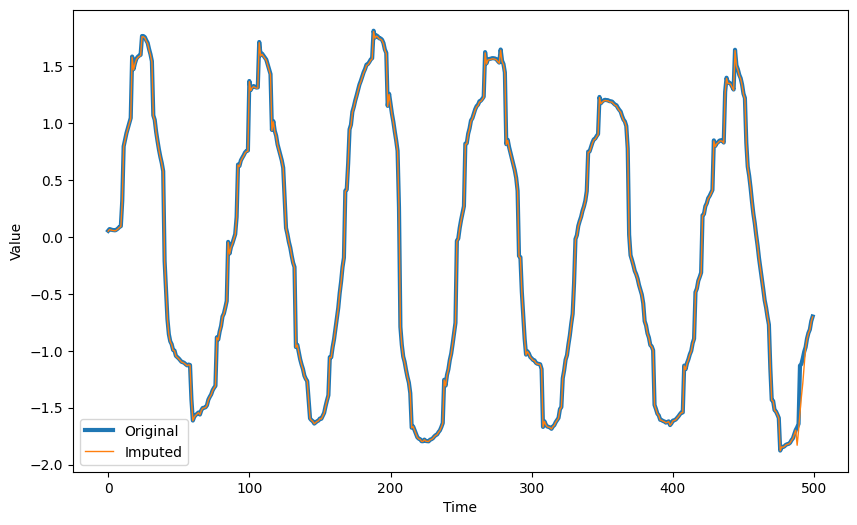

: 

In [69]:
reshaped_results_all = np.squeeze(imputation_test)
reshaped_x_test = np.squeeze(X_test_ori)


plt.figure(figsize=(10, 6))
plt.plot(reshaped_x_test[30], label='Original', linewidth=3)
plt.plot(reshaped_results_all[30], label='Imputed', linestyle='-', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()